<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/16/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN  `Model.train_step`

(https://twitter.com/fchollet)


## Загрузка модулей

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## строим Fashion_MNIST data

In [ ]:
# fashion MNIST 
class_ = 2
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_digits = all_digits[ind_i,:,:]
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
import matplotlib.pyplot as plt


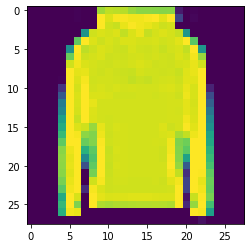

In [ ]:
plt.imshow(all_digits[101,:,:,0])
plt.show()

## Строим discriminator

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [ ]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              407680    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 256)      524544    
 ranspose)                                               

## Класс со своим этапом обучения `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


## Callback для сохранения изображений по ходу обучения

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        image = generated_images.numpy()
        plt.figure(figsize = (self.num_img*4, 4))
        for i in range(self.num_img):
          plt.subplot(1,self.num_img,i+1)
          plt.imshow(image[i,:,:,0])
        plt.show()
        #for i in range(self.num_img):
        #    img = keras.preprocessing.image.array_to_img(generated_images[i])
        #    img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Учим end-to-end модель

Epoch 1/40
94/94 [==============================] - ETA: 0s - d_loss: 0.5086 - g_loss: 0.7845

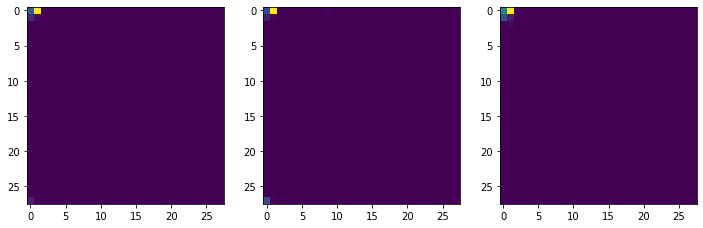

94/94 [==============================] - 19s 53ms/step - d_loss: 0.5068 - g_loss: 0.7859
Epoch 2/40
94/94 [==============================] - ETA: 0s - d_loss: 0.1753 - g_loss: 1.7859

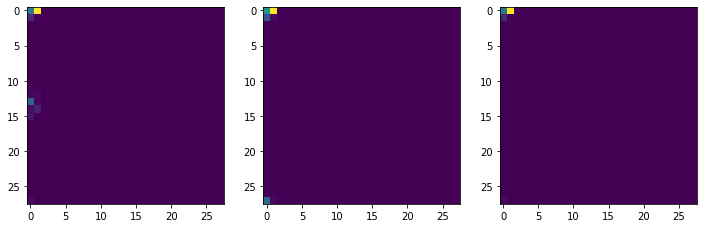

94/94 [==============================] - 5s 48ms/step - d_loss: 0.1744 - g_loss: 1.7987
Epoch 3/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.4534 - g_loss: 1.9983

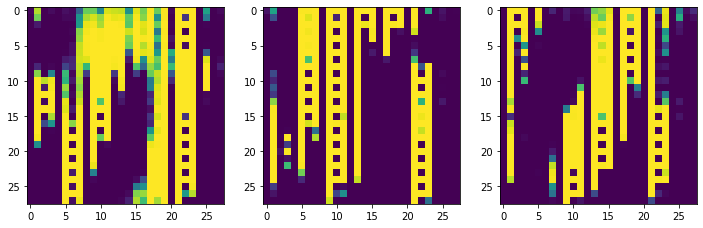

94/94 [==============================] - 5s 48ms/step - d_loss: 0.4567 - g_loss: 1.9780
Epoch 4/40
94/94 [==============================] - ETA: 0s - d_loss: 0.3389 - g_loss: 1.9664

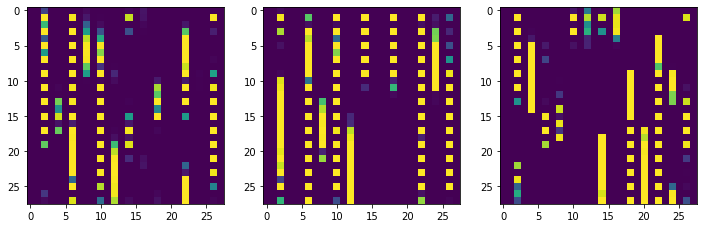

94/94 [==============================] - 4s 48ms/step - d_loss: 0.3364 - g_loss: 1.9798
Epoch 5/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0795 - g_loss: 3.4824

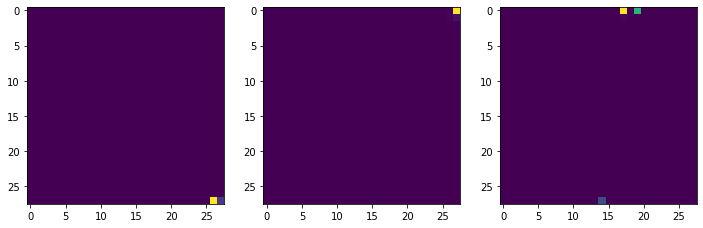

94/94 [==============================] - 4s 48ms/step - d_loss: 0.0792 - g_loss: 3.4928
Epoch 6/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0457 - g_loss: 4.5949

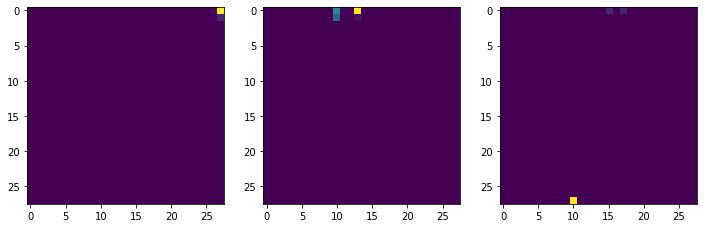

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0457 - g_loss: 4.6006
Epoch 7/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0270 - g_loss: 5.6215

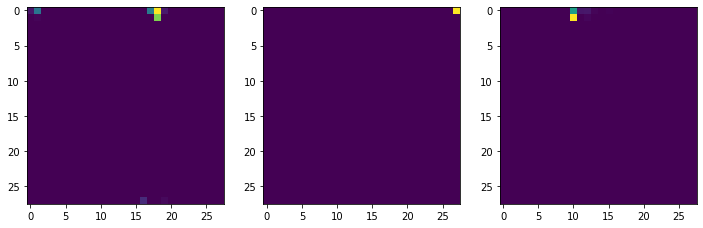

94/94 [==============================] - 5s 48ms/step - d_loss: 0.0270 - g_loss: 5.6268
Epoch 8/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0121 - g_loss: 6.5601

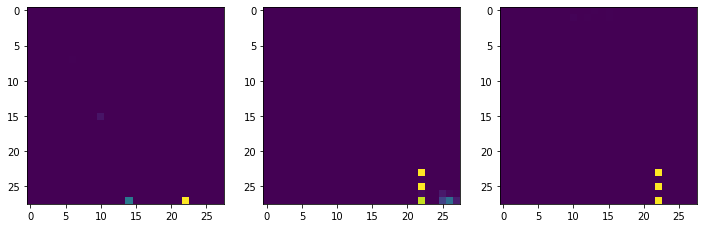

94/94 [==============================] - 5s 48ms/step - d_loss: 0.0120 - g_loss: 6.5593
Epoch 9/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4978 - g_loss: 2.0081

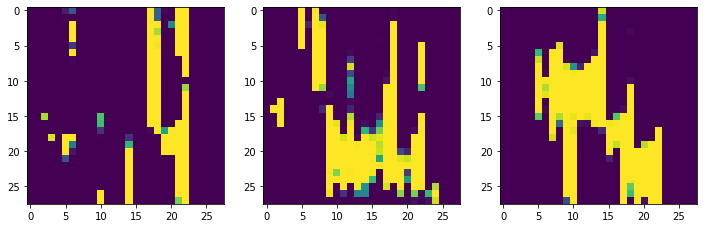

94/94 [==============================] - 5s 49ms/step - d_loss: 0.4961 - g_loss: 2.0064
Epoch 10/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.3363 - g_loss: 1.8646

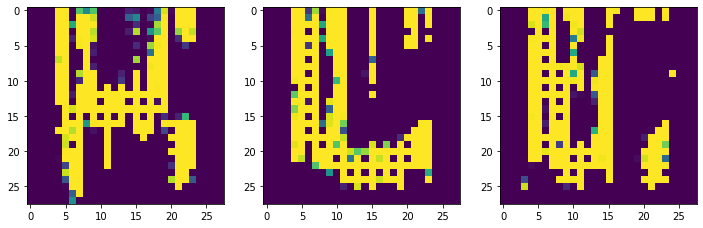

94/94 [==============================] - 5s 49ms/step - d_loss: 0.3350 - g_loss: 1.8683
Epoch 11/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2146 - g_loss: 2.7575

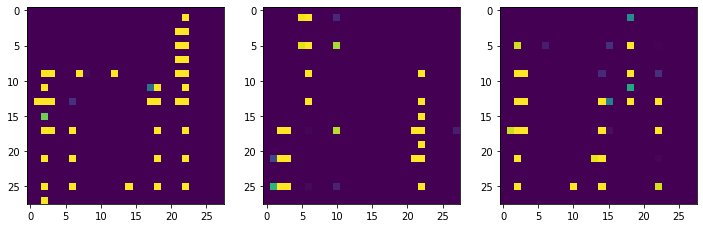

94/94 [==============================] - 5s 49ms/step - d_loss: 0.2128 - g_loss: 2.7760
Epoch 12/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.3286 - g_loss: 2.7352

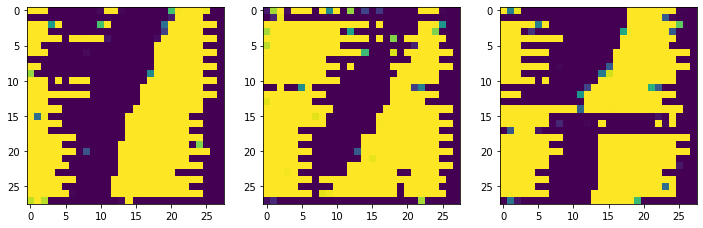

94/94 [==============================] - 5s 55ms/step - d_loss: 0.3312 - g_loss: 2.7146
Epoch 13/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2843 - g_loss: 2.6026

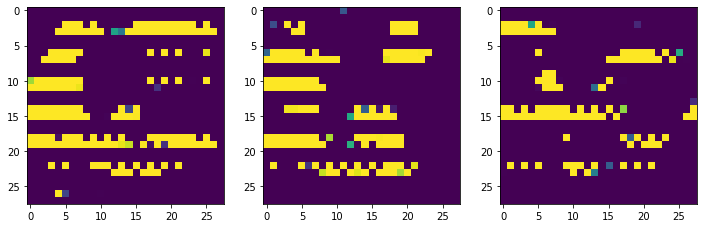

94/94 [==============================] - 5s 49ms/step - d_loss: 0.2821 - g_loss: 2.6163
Epoch 14/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2964 - g_loss: 2.3333

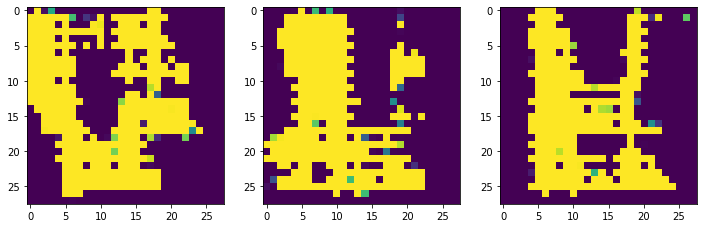

94/94 [==============================] - 5s 51ms/step - d_loss: 0.2954 - g_loss: 2.3318
Epoch 15/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.1908 - g_loss: 2.4586

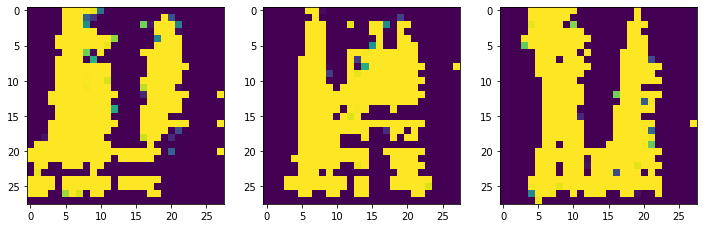

94/94 [==============================] - 5s 49ms/step - d_loss: 0.1898 - g_loss: 2.4576
Epoch 16/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.1898 - g_loss: 2.4839

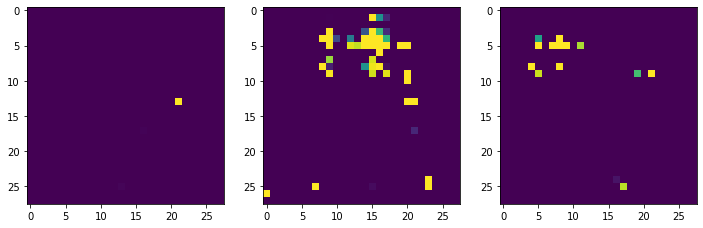

94/94 [==============================] - 5s 50ms/step - d_loss: 0.1912 - g_loss: 2.4661
Epoch 17/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0905 - g_loss: 3.6781

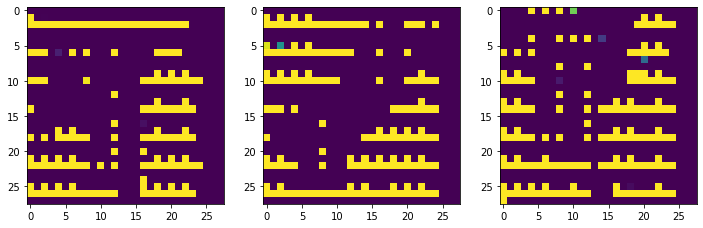

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0898 - g_loss: 3.6897
Epoch 18/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.1049 - g_loss: 4.1818

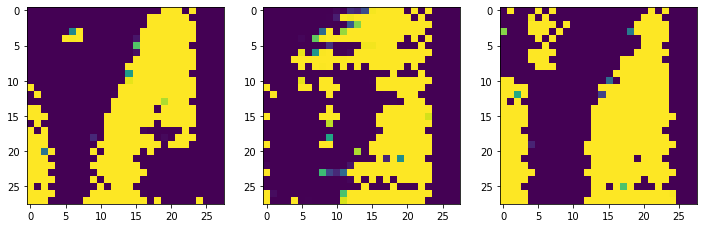

94/94 [==============================] - 5s 50ms/step - d_loss: 0.1055 - g_loss: 4.1584
Epoch 19/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.1187 - g_loss: 3.1862

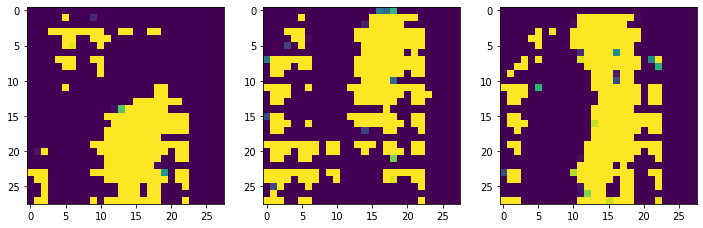

94/94 [==============================] - 5s 52ms/step - d_loss: 0.1192 - g_loss: 3.1741
Epoch 20/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0865 - g_loss: 3.6803

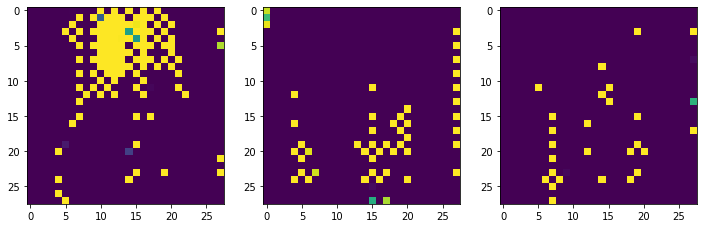

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0858 - g_loss: 3.6881
Epoch 21/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0593 - g_loss: 4.1811

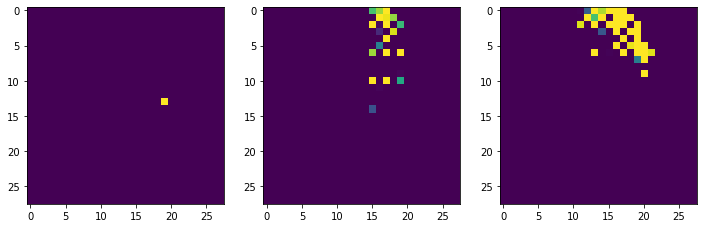

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0590 - g_loss: 4.1816
Epoch 22/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0373 - g_loss: 5.2981

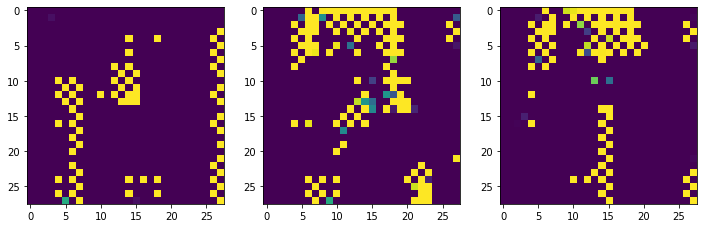

94/94 [==============================] - 5s 51ms/step - d_loss: 0.0371 - g_loss: 5.2787
Epoch 23/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0480 - g_loss: 4.5739

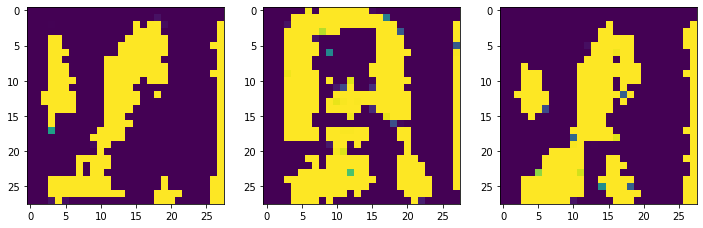

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0480 - g_loss: 4.5537
Epoch 24/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0636 - g_loss: 4.0010

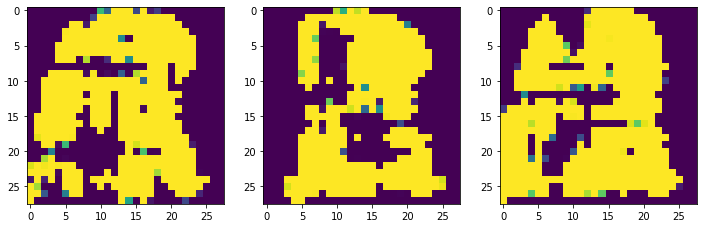

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0641 - g_loss: 3.9996
Epoch 25/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0828 - g_loss: 3.6353

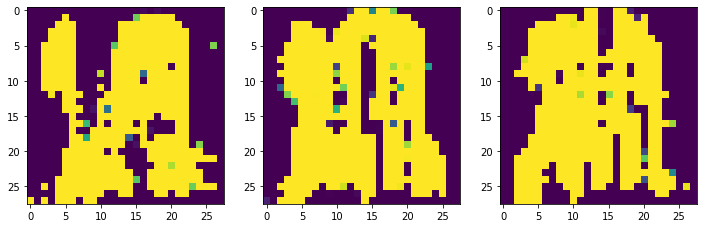

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0846 - g_loss: 3.6188
Epoch 26/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0956 - g_loss: 3.5025

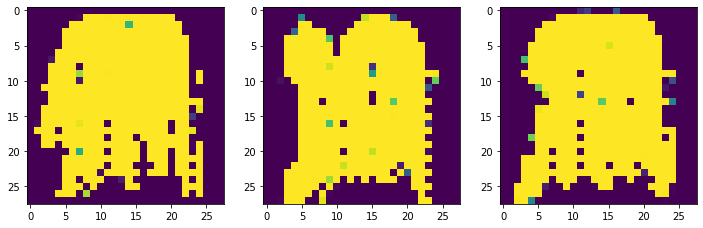

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0955 - g_loss: 3.5024
Epoch 27/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0980 - g_loss: 3.4662

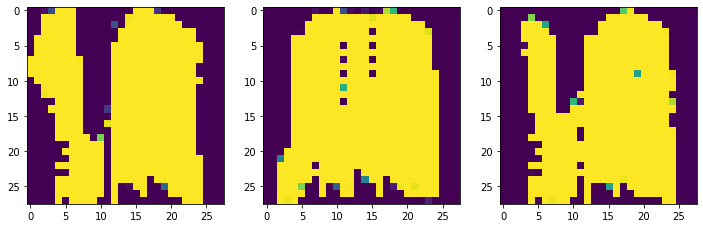

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0979 - g_loss: 3.4675
Epoch 28/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0897 - g_loss: 3.7599

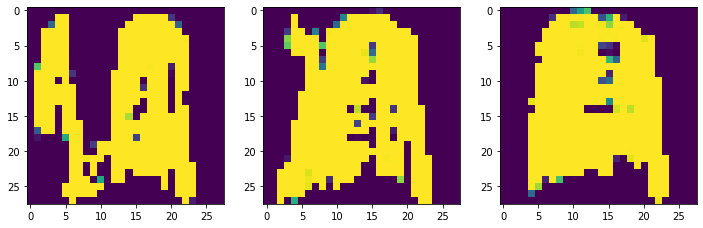

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0897 - g_loss: 3.7563
Epoch 29/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0928 - g_loss: 3.6497

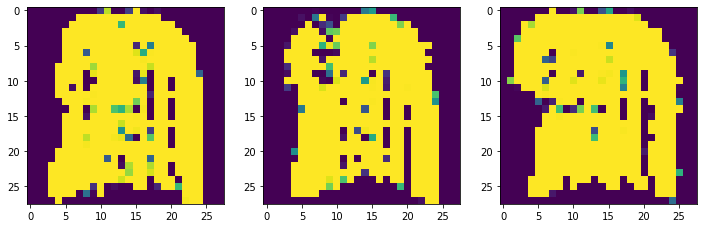

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0928 - g_loss: 3.6488
Epoch 30/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0870 - g_loss: 3.7253

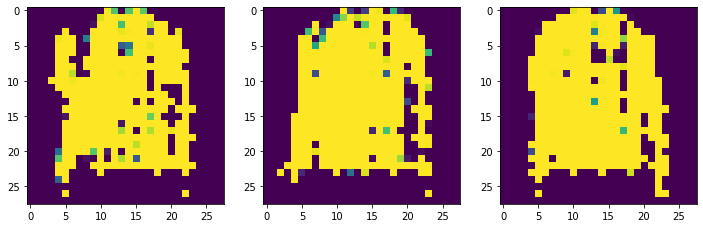

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0870 - g_loss: 3.7288
Epoch 31/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0840 - g_loss: 3.8325

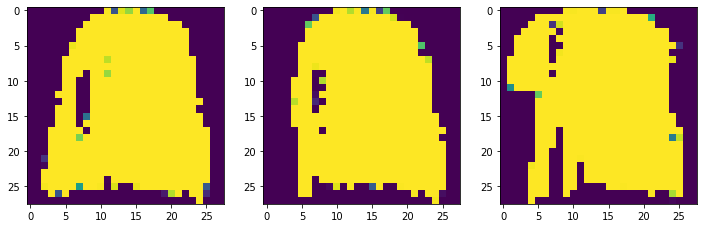

94/94 [==============================] - 5s 49ms/step - d_loss: 0.0840 - g_loss: 3.8313
Epoch 32/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0656 - g_loss: 4.3701

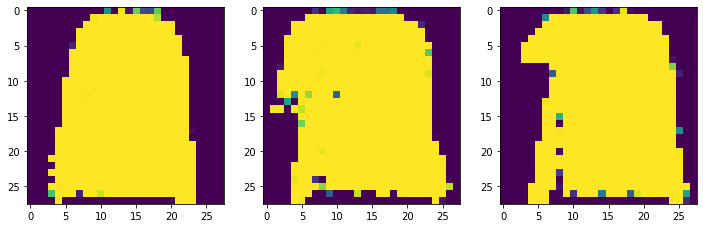

94/94 [==============================] - 5s 51ms/step - d_loss: 0.0652 - g_loss: 4.3839
Epoch 33/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.0837 - g_loss: 4.1001

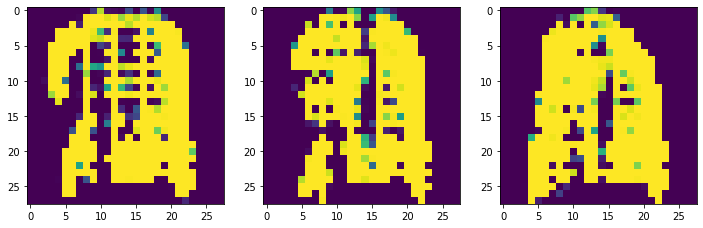

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0835 - g_loss: 4.1043
Epoch 34/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0751 - g_loss: 4.0157

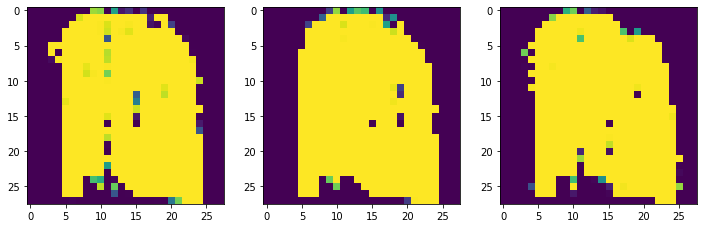

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0753 - g_loss: 4.0144
Epoch 35/40
94/94 [==============================] - ETA: 0s - d_loss: 0.0807 - g_loss: 4.0104

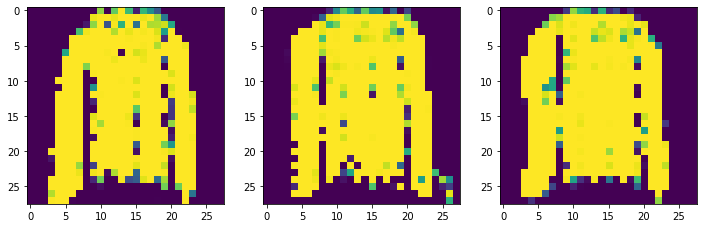

94/94 [==============================] - 5s 50ms/step - d_loss: 0.0806 - g_loss: 4.0079
Epoch 36/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.1186 - g_loss: 3.3708

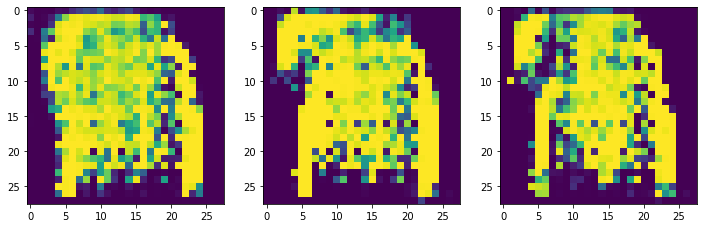

94/94 [==============================] - 5s 51ms/step - d_loss: 0.1204 - g_loss: 3.3444
Epoch 37/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6314 - g_loss: 1.8141

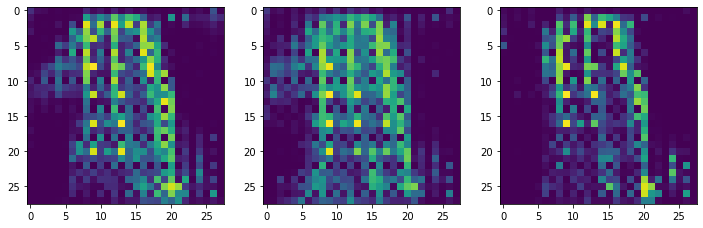

94/94 [==============================] - 5s 51ms/step - d_loss: 0.6305 - g_loss: 1.8108
Epoch 38/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7485 - g_loss: 1.1675

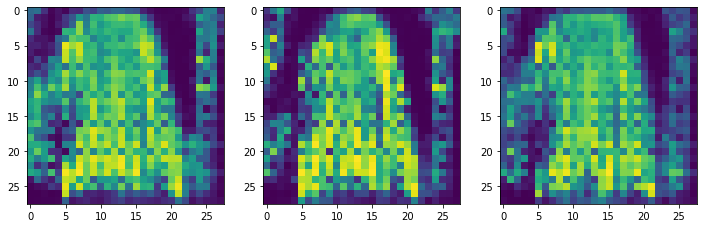

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7505 - g_loss: 1.1643
Epoch 39/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7118 - g_loss: 0.9872

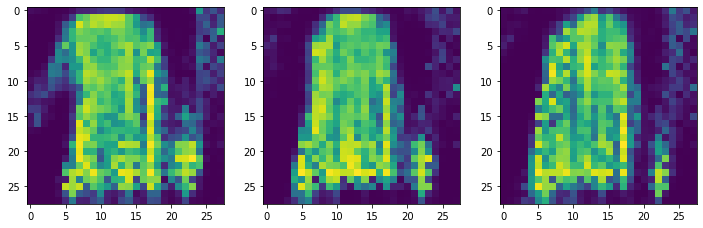

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7122 - g_loss: 0.9858
Epoch 40/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6337 - g_loss: 1.0482

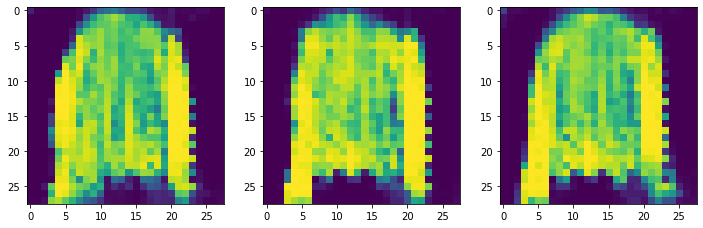

94/94 [==============================] - 5s 51ms/step - d_loss: 0.6390 - g_loss: 1.0447


In [ ]:
epochs = 40

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Display the last generated images:

Epoch 1/40
94/94 [==============================] - ETA: 0s - d_loss: 0.5347 - g_loss: 1.3858

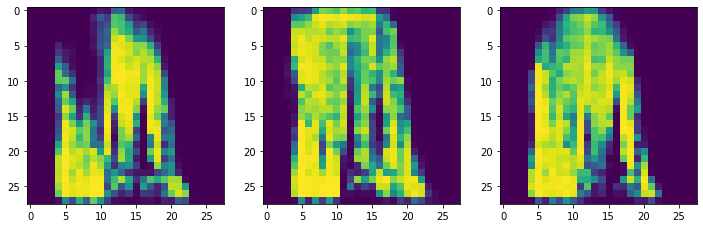

94/94 [==============================] - 5s 49ms/step - d_loss: 0.5322 - g_loss: 1.3885
Epoch 2/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.5524 - g_loss: 1.1972

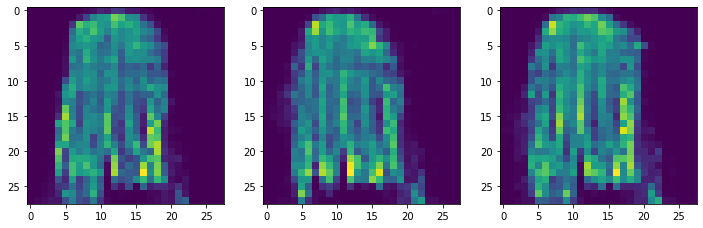

94/94 [==============================] - 5s 48ms/step - d_loss: 0.5528 - g_loss: 1.1962
Epoch 3/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.5784 - g_loss: 1.2631

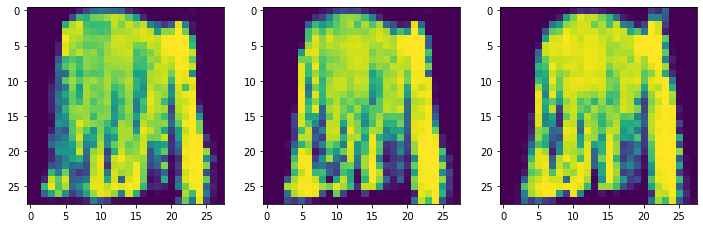

94/94 [==============================] - 5s 49ms/step - d_loss: 0.5811 - g_loss: 1.2609
Epoch 4/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7452 - g_loss: 0.9263

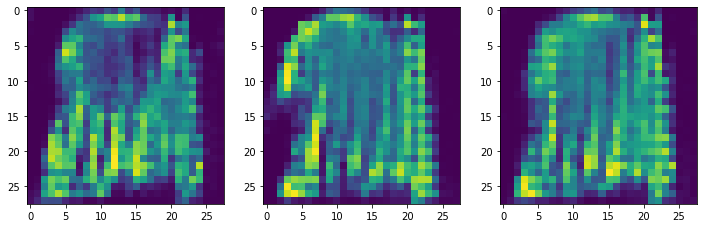

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7460 - g_loss: 0.9253
Epoch 5/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7999 - g_loss: 0.8486

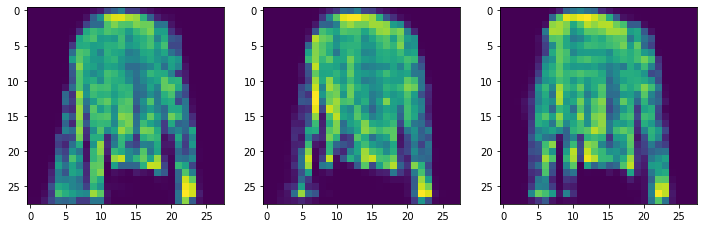

94/94 [==============================] - 5s 51ms/step - d_loss: 0.7981 - g_loss: 0.8490
Epoch 6/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6533 - g_loss: 1.0254

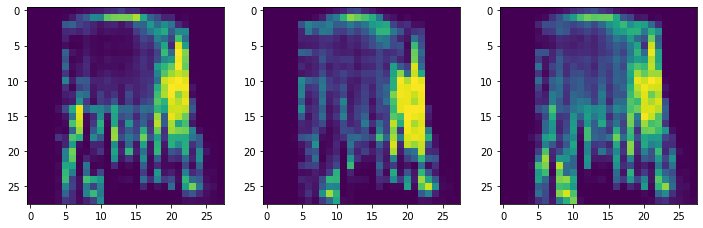

94/94 [==============================] - 5s 49ms/step - d_loss: 0.6507 - g_loss: 1.0282
Epoch 7/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6263 - g_loss: 1.0700

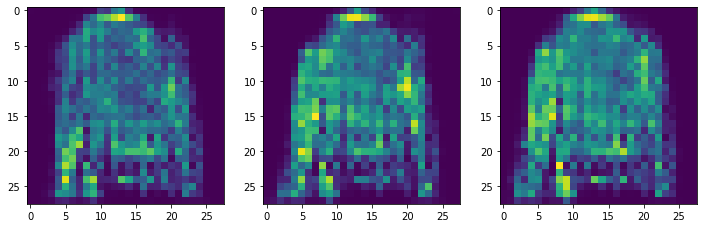

94/94 [==============================] - 5s 49ms/step - d_loss: 0.6271 - g_loss: 1.0668
Epoch 8/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7595 - g_loss: 0.8642

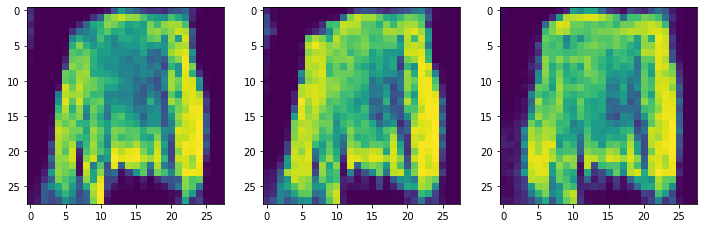

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7643 - g_loss: 0.8644
Epoch 9/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6787 - g_loss: 0.9715

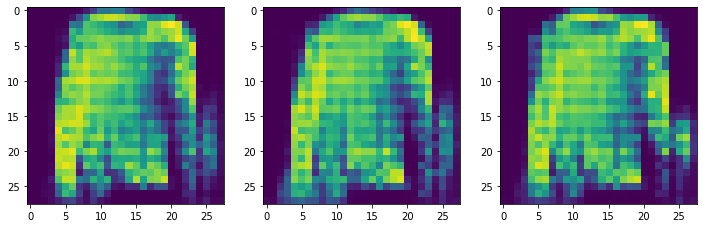

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6792 - g_loss: 0.9722
Epoch 10/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6860 - g_loss: 0.9746

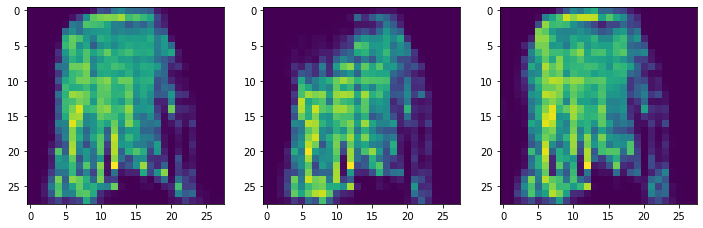

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6846 - g_loss: 0.9761
Epoch 11/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7619 - g_loss: 0.8579

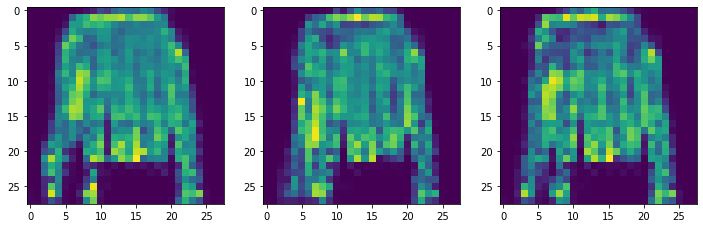

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7613 - g_loss: 0.8568
Epoch 12/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7546 - g_loss: 0.7806

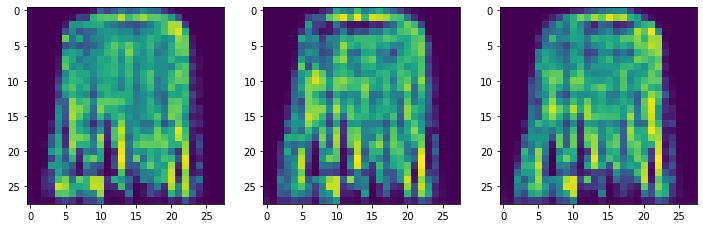

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7552 - g_loss: 0.7798
Epoch 13/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7094 - g_loss: 0.8597

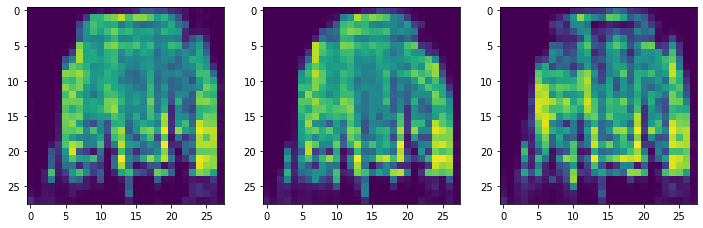

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7105 - g_loss: 0.8591
Epoch 14/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.5296 - g_loss: 1.1047

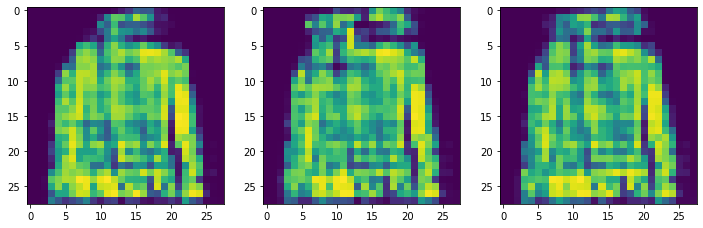

94/94 [==============================] - 5s 50ms/step - d_loss: 0.5311 - g_loss: 1.1036
Epoch 15/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6358 - g_loss: 0.9778

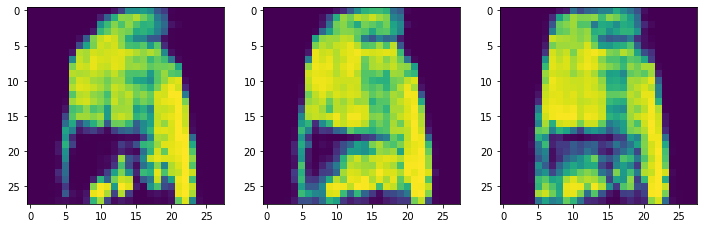

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6367 - g_loss: 0.9811
Epoch 16/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.5595 - g_loss: 1.1369

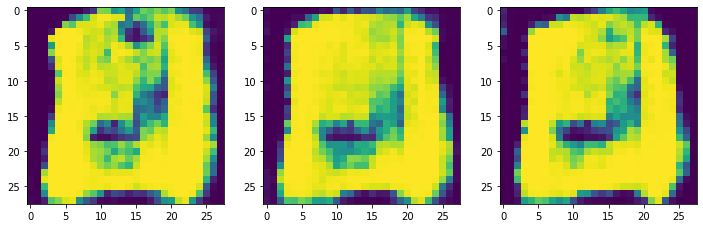

94/94 [==============================] - 5s 49ms/step - d_loss: 0.5697 - g_loss: 1.1277
Epoch 17/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7448 - g_loss: 0.9327

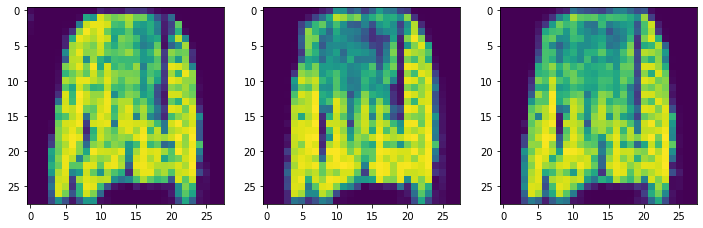

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7459 - g_loss: 0.9329
Epoch 18/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7278 - g_loss: 0.8736

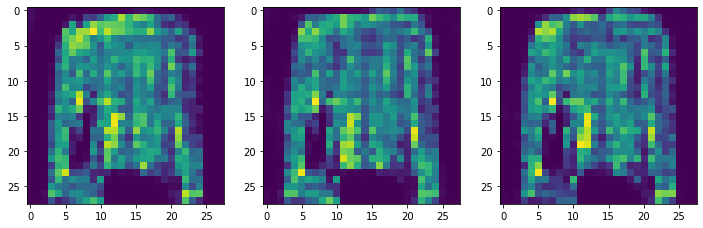

94/94 [==============================] - 5s 51ms/step - d_loss: 0.7287 - g_loss: 0.8698
Epoch 19/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6458 - g_loss: 0.9842

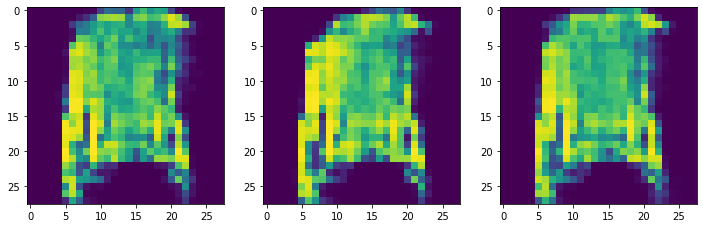

94/94 [==============================] - 5s 49ms/step - d_loss: 0.6447 - g_loss: 0.9868
Epoch 20/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6021 - g_loss: 1.0085

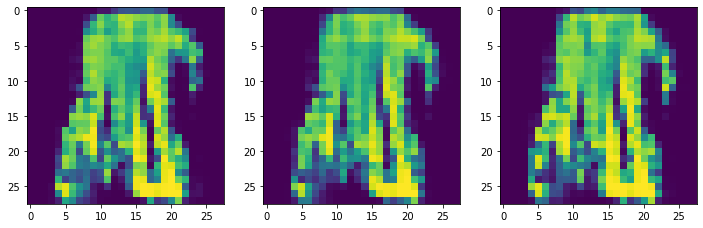

94/94 [==============================] - 5s 49ms/step - d_loss: 0.6032 - g_loss: 1.0065
Epoch 21/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6138 - g_loss: 0.9662

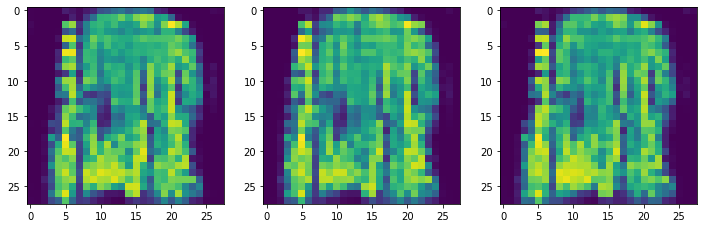

94/94 [==============================] - 5s 49ms/step - d_loss: 0.6203 - g_loss: 0.9606
Epoch 22/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7447 - g_loss: 0.8676

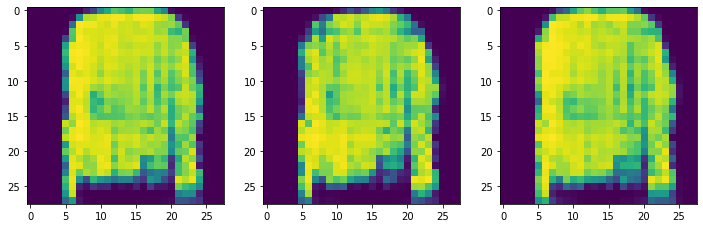

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7425 - g_loss: 0.8702
Epoch 23/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7156 - g_loss: 0.9189

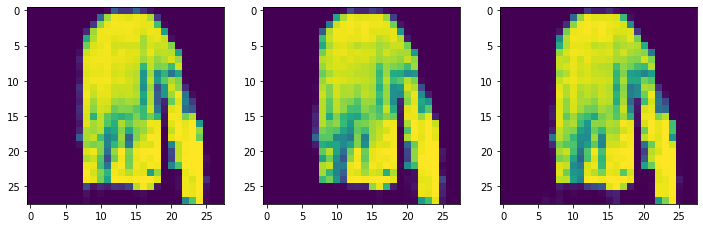

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7146 - g_loss: 0.9206
Epoch 24/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.4010 - g_loss: 1.4671

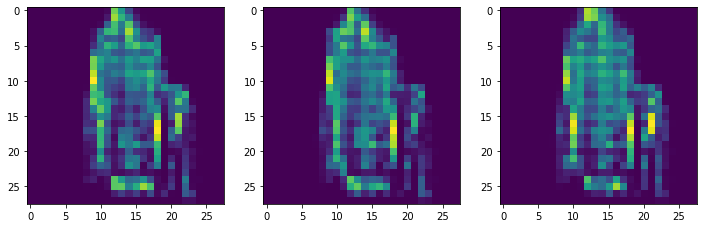

94/94 [==============================] - 5s 50ms/step - d_loss: 0.4106 - g_loss: 1.4523
Epoch 25/40
94/94 [==============================] - ETA: 0s - d_loss: 0.4628 - g_loss: 1.3346

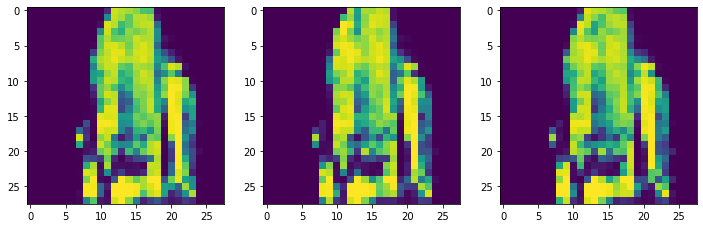

94/94 [==============================] - 5s 50ms/step - d_loss: 0.4612 - g_loss: 1.3371
Epoch 26/40
94/94 [==============================] - ETA: 0s - d_loss: 0.3396 - g_loss: 1.5866

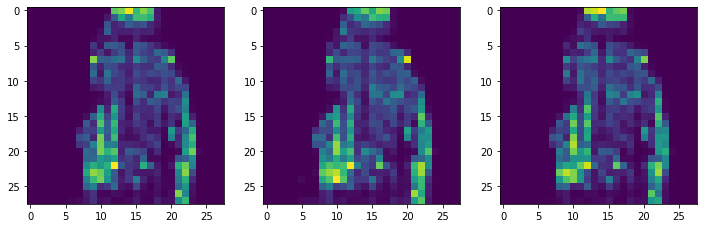

94/94 [==============================] - 5s 50ms/step - d_loss: 0.3400 - g_loss: 1.5863
Epoch 27/40
94/94 [==============================] - ETA: 0s - d_loss: 0.3119 - g_loss: 1.7727

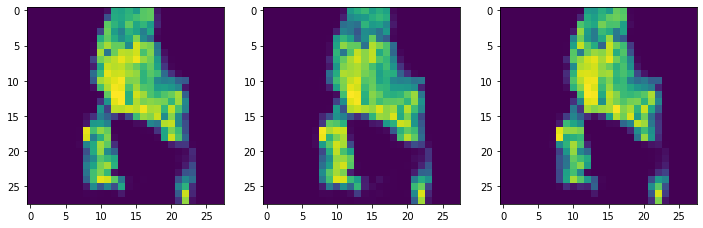

94/94 [==============================] - 5s 50ms/step - d_loss: 0.3110 - g_loss: 1.7738
Epoch 28/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.2836 - g_loss: 1.8548

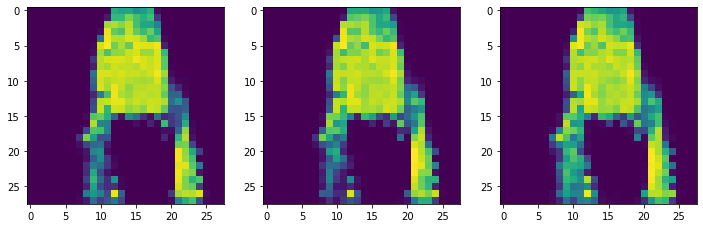

94/94 [==============================] - 5s 50ms/step - d_loss: 0.2855 - g_loss: 1.8573
Epoch 29/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.2721 - g_loss: 1.8973

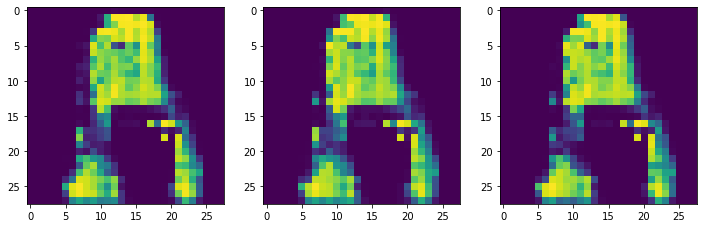

94/94 [==============================] - 5s 50ms/step - d_loss: 0.2724 - g_loss: 1.8986
Epoch 30/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2824 - g_loss: 1.9331

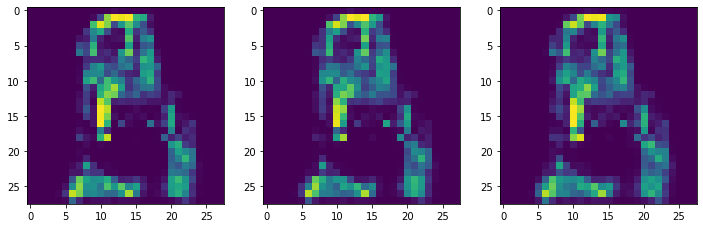

94/94 [==============================] - 5s 49ms/step - d_loss: 0.2823 - g_loss: 1.9343
Epoch 31/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.2341 - g_loss: 2.2422

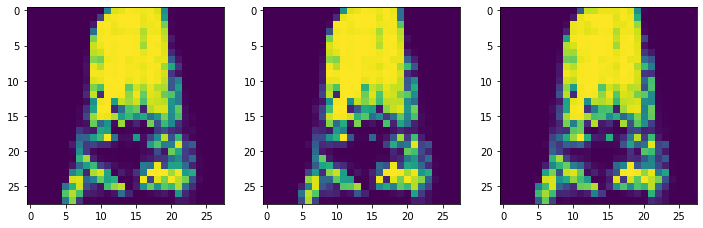

94/94 [==============================] - 5s 51ms/step - d_loss: 0.2330 - g_loss: 2.2427
Epoch 32/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.2429 - g_loss: 2.1578

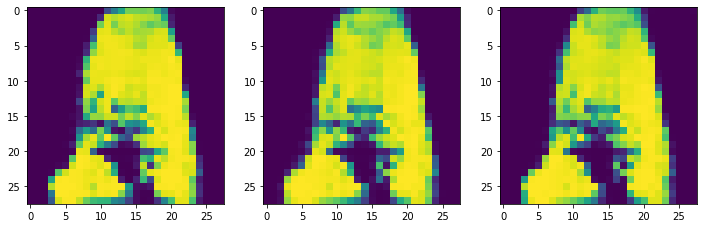

94/94 [==============================] - 5s 50ms/step - d_loss: 0.2433 - g_loss: 2.1643
Epoch 33/40
94/94 [==============================] - ETA: 0s - d_loss: 0.2280 - g_loss: 2.3054

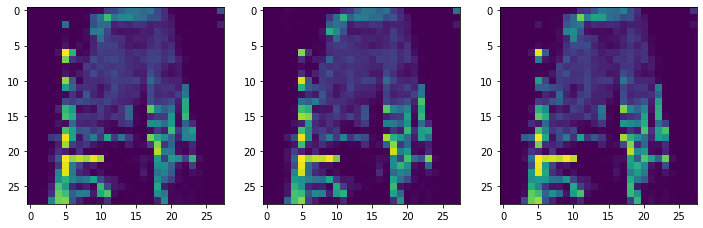

94/94 [==============================] - 5s 49ms/step - d_loss: 0.2290 - g_loss: 2.3025
Epoch 34/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.7599 - g_loss: 1.0708

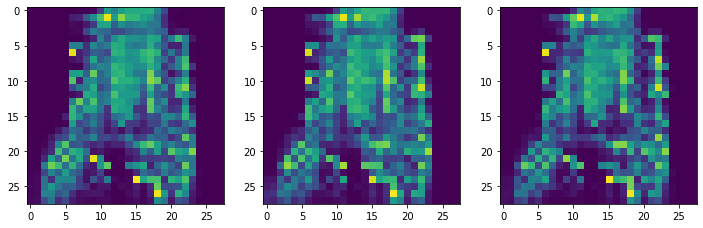

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7559 - g_loss: 1.0747
Epoch 35/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7054 - g_loss: 1.1499

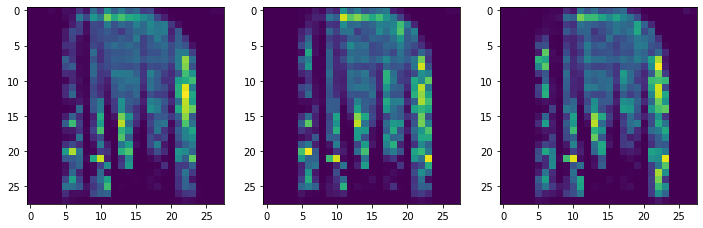

94/94 [==============================] - 5s 50ms/step - d_loss: 0.7091 - g_loss: 1.1419
Epoch 36/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6971 - g_loss: 0.9869

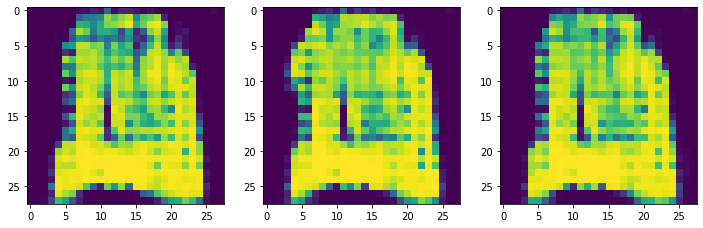

94/94 [==============================] - 5s 51ms/step - d_loss: 0.6937 - g_loss: 0.9916
Epoch 37/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6766 - g_loss: 0.9040

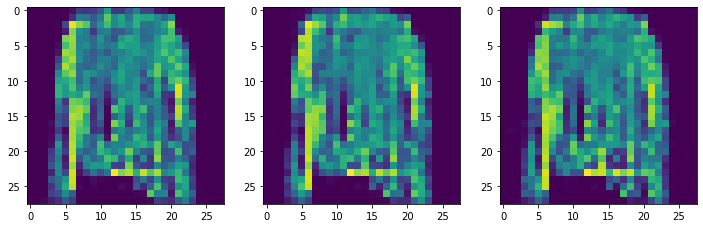

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6763 - g_loss: 0.9033
Epoch 38/40
94/94 [==============================] - ETA: 0s - d_loss: 0.7508 - g_loss: 0.7871

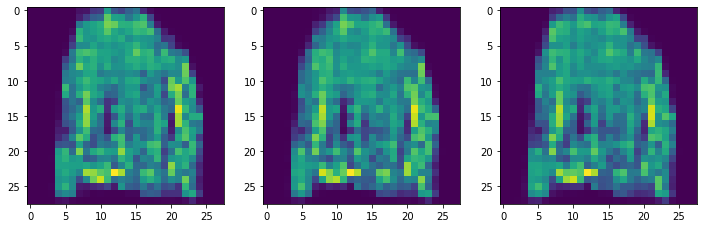

94/94 [==============================] - 5s 49ms/step - d_loss: 0.7508 - g_loss: 0.7867
Epoch 39/40
94/94 [==============================] - ETA: 0s - d_loss: 0.6472 - g_loss: 0.8888

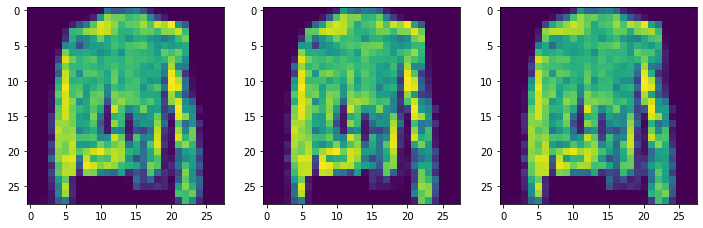

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6494 - g_loss: 0.8873
Epoch 40/40
93/94 [============================>.] - ETA: 0s - d_loss: 0.6908 - g_loss: 0.8983

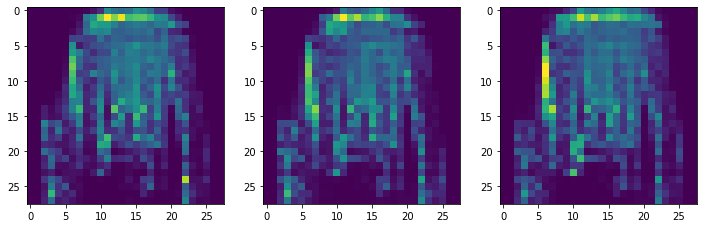

94/94 [==============================] - 5s 50ms/step - d_loss: 0.6848 - g_loss: 0.9043


In [ ]:
history = gan.fit(
    dataset, epochs=40, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

NameError: ignored

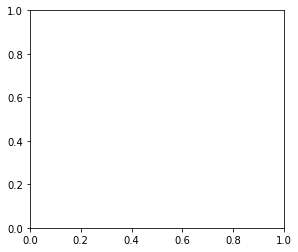

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(history.history['d_loss'])
plt.title('d_loss')
plt.xlabel('epoch')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['g_loss'])
plt.title('g_loss')
plt.xlabel('epoch')
plt.grid(True)
2

plt.show()

In [ ]:
I = gan.generator(tf.random.normal(shape=(1, gan.latent_dim)))

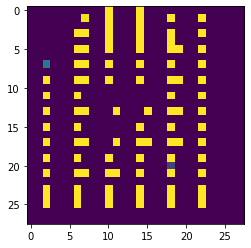

In [ ]:
plt.imshow(I[0,:,:,0])
plt.show()